# CS-6570 Lecture 9 - Variable Selection for Linear Models

**Dylan Zwick**

*Weber State University*

In our last class, we discussed how in the regression setting, the standard linear model:

&nbsp;
<center>
    $Y = \beta_{0} + \beta_{1}X_{1} + \cdots + \beta_{p}X_{p} + \epsilon$
</center>
&nbsp;

in used to attempt to describe the relationship between a response $Y$ and a set of variables $X_{1},X_{2},\ldots,X_{p}$. The approach taken is to find the values of $\beta_{0},\beta_{1},\ldots,\beta_{p}$ that minimize the residual sum of squares:


&nbsp;
<center>
    $\displaystyle RSS = \sum_{i = 1}^{n}(y_{i} - \hat{y}_{i})^{2}$
</center>
&nbsp;
<center>
    $\displaystyle \hat{y}_{i} = \beta_{0} + \beta_{1}x_{i1} + \cdots + \beta_{p}x_{ip}$
</center>
&nbsp;

Not unusually, and with growing frequency, for real-world applications there are a lot of potential inputs to a model. If you were to attempt to build a predictive model for, say, the S&P 500, some potential inputs could be the history of every single stock on the market, the currency exchange rates throughout the world, government employment numbers, weather patterns, television viewership figures - you name it! Any and all of these inputs might potentially have some impact on the movement of the index.

You might be tempted to throw all these variables into your model and see what you can predict. However, you'll quickly run into two issues:

- _Model Interpretability_ - If you want to try to understand why and how your model is predicting the way it is, the more input variables you have, the more complicated, convoluted, and contrived your explanation will become.

- _Prediction Accuracy_ - This is even worse. With more variables, your model may start to overfit the data you use to build your model - doing well on data it's seen before, but poorly on the new data that you really want to predict.

Unfortunately, the metrics we use to gauge the fit of a regression model, RSS and its scaled counterpart $R^{2}$, offer no help for this problem. When we add more variables to our model, RSS will _always_ decrease, and the $R^{2}$ value will _always_ increase, at least on the data we're using to build the model (frequently known as the training data).

Let's take a look at this issue in the context of an example, but first let's import our standard libraries.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

The dataset we'll use is some *simulated* credit data from the book *An Introduction to Statistical Learning* with Python (although the R book uses the same dataset). You can find the book [here](https://www.statlearning.com/), and the dataset [here](https://www.statlearning.com/resources-python).

In [6]:
import os
os.getcwd()

'/home/e930b992-a9bf-43e9-98f5-95aaaf79bdea/CS-6570/Lecture Notes'

In [7]:
os.chdir(os.getcwd() + '/Lecture 9')

In [8]:
credit = pd.read_csv('Credit.csv')

credit.head()

,Income,Limit,Rating,Cards,Age,Education,Own,Student,Married,Region,Balance
0,14.891,3606,283,2,34,11,No,No,Yes,South,333
1,106.025,6645,483,3,82,15,Yes,Yes,Yes,West,903
2,104.593,7075,514,4,71,11,No,No,No,West,580
3,148.924,9504,681,3,36,11,Yes,No,No,West,964
4,55.882,4897,357,2,68,16,No,No,Yes,South,331


Let's use the data here to try to predict the credit card balance of the "people" in this dataset. We'll want to change the "Own", "Student", and "Married" variables into binary numeric indicators. The "Region" variable has four categorical values, which presents a complication. We'll talk about ways we can use categorical variables in a later class, but today we'll just do the easy thing and not use that variable.

In [10]:
#Define the variables we'll be using for predictions.
predictors = ['Income', 'Limit', 'Rating', 'Cards', 'Age', 'Education', 'Own', 'Student', 'Married']
#Define the variable we'll be predicting.
target = 'Balance'

#Translate the Yes/No variables into binary 1/0 variables.
credit['Own'] = credit['Own'].map({'No':0,'Yes':1})
credit['Student'] = credit['Student'].map({'No':0,'Yes':1})
credit['Married'] = credit['Married'].map({'No':0,'Yes':1})

credit.head()

,Income,Limit,Rating,Cards,Age,Education,Own,Student,Married,Region,Balance
0,14.891,3606,283,2,34,11,0,0,1,South,333
1,106.025,6645,483,3,82,15,1,1,1,West,903
2,104.593,7075,514,4,71,11,0,0,0,West,580
3,148.924,9504,681,3,36,11,1,0,0,West,964
4,55.882,4897,357,2,68,16,0,0,1,South,331


In [11]:
from sklearn import linear_model
regr = linear_model.LinearRegression()

X = credit[predictors].to_numpy()
y = credit[target].to_numpy()

for n in range(len(predictors)):
    X = credit[predictors[0:n+1]].to_numpy()
    regr.fit(X,y)
    print("For predictors {} \n the r-squared value is {}\n".format(predictors[0:n+1],regr.score(X,y)))

For predictors ['Income'] 
 the r-squared value is 0.21497731013240495

For predictors ['Income', 'Limit'] 
 the r-squared value is 0.8711069068154775

For predictors ['Income', 'Limit', 'Rating'] 
 the r-squared value is 0.8762389456262863

For predictors ['Income', 'Limit', 'Rating', 'Cards'] 
 the r-squared value is 0.8769925315982247

For predictors ['Income', 'Limit', 'Rating', 'Cards', 'Age'] 
 the r-squared value is 0.8780622591439674

For predictors ['Income', 'Limit', 'Rating', 'Cards', 'Age', 'Education'] 
 the r-squared value is 0.878245293186235

For predictors ['Income', 'Limit', 'Rating', 'Cards', 'Age', 'Education', 'Own'] 
 the r-squared value is 0.8782624096046839

For predictors ['Income', 'Limit', 'Rating', 'Cards', 'Age', 'Education', 'Own', 'Student'] 
 the r-squared value is 0.954880680193512

For predictors ['Income', 'Limit', 'Rating', 'Cards', 'Age', 'Education', 'Own', 'Student', 'Married'] 
 the r-squared value is 0.954934571882831



OK, so if RSS and $R^{2}$ won't allow us to differentiate among potential models - how should we do it? Well, there are a few statistical measures that do take into account the size of our model and penalize larger models. Some of these are:

**Mallow's Cp**

Named after Colin Lingwood Mallows it is defined as:

&nbsp;
<center>
    $\displaystyle C_{p} = \frac{1}{n}\left(RSS + 2d\hat{\sigma}^{2}\right)$
</center>
&nbsp;

where $\hat{\sigma}^2$ is an estimate of the variance of the error ϵ associated with each response measurement. Typically σ^2 is estimated using the full model containing all predictors.

&nbsp;
<center>
    $\displaystyle \hat{\sigma}^{2} = \frac{RSS}{n-p-1}$
</center>
&nbsp;

where $p$ is the number of predictors.

**Bayesian Information Criterion (BIC)**

BIC is derived from a Bayesian point of view, and looks similar to Mallow's $C_{p}$. It is defined (up to irrelevant constants) as:

&nbsp;
<center>
    $\displaystyle BIC = \frac{1}{n}\left(RSS + \log{(n)}d\hat{\sigma}^{2}\right)$
</center>
&nbsp;

Like $C_{p}$, the BIC will tend to take small values for a model with low test error.

**Adjusted $R^{2}$**

Since the $R^{2}$ always increases as more variables are added, the adjusted $R^{2}$ accounts for that fact and introduces a penalty. The intuition is that once all the correct variables have been included in the model, additional noise variables will lead to a very small decrase in RSS, but an increase in k and hence will decrease the adjusted $R^{2}$. In effect, we pay a price for the inclusion of unnecessary variables in the model.

&nbsp;
<center>
    $\displaystyle R^{2}_{a} = 1-\frac{RSS/(n-k-1)}{TSS/n-1}$
</center>
&nbsp;

$C_{p}$ and $BIC$ have rigorous theoretical justification that rely on asymptotic arguments, i.e. when the sample size $n$ grows very large, they become precise, whereas the adjusted $R^{2}$, although quite intuitive, is not as well motivated in statistical theory. However... it works.

Based on these measures, how can we then determine an optimal subset of predictor variables to use? Well, generally speaking, there are three approaches:

- Check *all* the possible subsets for the best option.
- Find the best possibility with 1 predictor, and then add on the best possible second predictor based on this first predictor, and so on. This is called forward stepwise selection.
- Find the best possibility with all predictors, and then subtract the least importand predictor based on the model with all predictors, and so on. THis is called backward stepwise selection.

**Best Subset Selection**
To perform best subset selection, we fit separate models for each possible combination of the $n$ predictors and then select the best subset. That is we fit:

- All models that contains exactly one predictor
- All models that contain 2 predictors at the second step: $n \choose{2}$
- Until reaching the end point where all $n$ predictors are included in the model

This results in $2^{n}$ possibilities. In our case there are $2^{9} = 512$ possible combinations

_Algorithm_

- Let $M_{0}$ denote the null model which contains no predictors, this model simply predicts the sample mean of each observation

- For $k=1,2,...,n$
    - Fit all $n \choose k$ models that contain exactly k predictors
    - Pick the best among these $n \choose k$ models, and call it $M_{k}$. Here the best is having the smallest $RSS$, or an equivalent measure.
 mo
- Select the single best model among $M_{0},M_{1},...,M_{n}$ using $C_{p}$, $BIC$, adjusted $R^{2}$ or any other method.

We can check out this method in Python using the _itertools_ module, but first, let's define a helper function for telling us the $RSS$ and $R^{2}$ values for a given regression model.

In [16]:
def fit_linear_reg(X,Y):
    #Fit linear regression model and return RSS and R squared values
    model_k = linear_model.LinearRegression()
    model_k.fit(X,Y)
    RSS = mean_squared_error(Y,model_k.predict(X)) * len(Y)
    R_squared = model_k.score(X,Y)
    return RSS, R_squared

Now, we can run through this process for our $9$ variables.

In [18]:
import itertools
from sklearn.metrics import mean_squared_error

#Initialization variables
Y = credit[target]
X = credit[predictors]

RSS_list, R_squared_list, feature_list = [],[], []
numb_features = []

#Looping over the features in X
for k in range(1,len(X.columns) + 1):
    #Looping over all possible combinations: from 9 choose k
    for combo in itertools.combinations(X.columns,k):
        tmp_result = fit_linear_reg(X[list(combo)],Y)   #Store temp result 
        RSS_list.append(tmp_result[0])                  #Append lists
        R_squared_list.append(tmp_result[1])
        feature_list.append(combo)
        numb_features.append(len(combo))   

#Store in DataFrame
df = pd.DataFrame({'numb_features': numb_features,'RSS': RSS_list, 'R_squared':R_squared_list,'features':feature_list})

In [19]:
df_min = df[df.groupby('numb_features')['RSS'].transform(min) == df['RSS']]
display(df_min)

,numb_features,RSS,R_squared,features
2,1,2.143512e+07,0.745848,"(Rating,)"
10,2,1.053254e+07,0.875118,"(Income, Rating)"
56,3,4.227219e+06,0.949879,"(Income, Rating, Student)"
138,4,3.915058e+06,0.953580,"(Income, Limit, Cards, Student)"
258,5,3.866091e+06,0.954161,"(Income, Limit, Rating, Cards, Student)"
383,6,3.821620e+06,0.954688,"(Income, Limit, Rating, Cards, Age, Student)"
468,7,3.810759e+06,0.954817,"(Income, Limit, Rating, Cards, Age, Own, Student)"
501,8,3.805359e+06,0.954881,"(Income, Limit, Rating, Cards, Age, Education,..."
510,9,3.800814e+06,0.954935,"(Income, Limit, Rating, Cards, Age, Education,..."


In [20]:
df['min_RSS'] = df.groupby('numb_features')['RSS'].transform(min)
df.head()

,numb_features,RSS,R_squared,features,min_RSS
0,1,6.620874e+07,0.214977,"(Income,)",2.143512e+07
1,1,2.171566e+07,0.742522,"(Limit,)",2.143512e+07
2,1,2.143512e+07,0.745848,"(Rating,)",2.143512e+07
3,1,8.370950e+07,0.007475,"(Cards,)",2.143512e+07
4,1,8.433963e+07,0.000003,"(Age,)",2.143512e+07


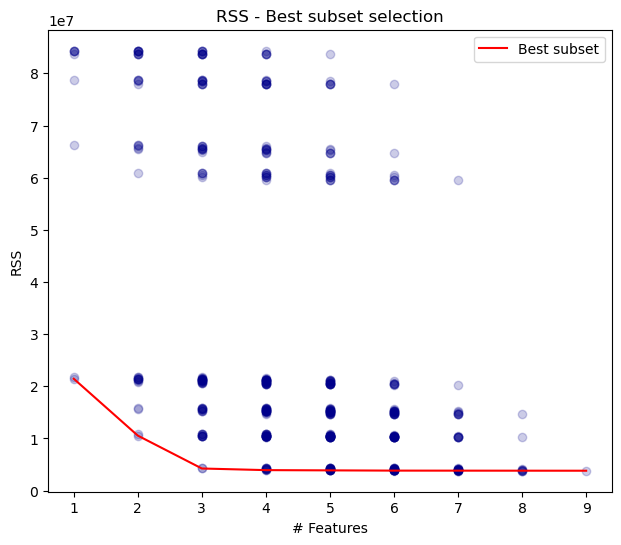

In [21]:
fig = plt.figure(figsize = (16,6))
ax = fig.add_subplot(1, 2, 1)

ax.scatter(df.numb_features,df.RSS, alpha = .2, color = 'darkblue' )
ax.set_xlabel('# Features')
ax.set_ylabel('RSS')
ax.set_title('RSS - Best subset selection')
ax.plot(df.numb_features,df.min_RSS,color = 'r', label = 'Best subset')
ax.legend()

plt.show()

**Forward Stepwise Selection**

For computational reasons, the best subset cannot be applied for large $n$ due to the $2^{n}$ complexity. Forward stepwise selection begins with a model containing no predictors, and then adds predictors to the model, one at the time. At each step, the variable that gives the greatest additional improvement to the fit is added to the model.

_Algorithm_

- Let $M_{0}$ denote the null model which contains no predictors.

- For $k=1,2,...,n-1$
    - Consider all $n-k$ that augment the predictors in $M_{k}$ with one additional predictor.
    - Pick the best among these $n - k$ models, and call in $M_{k+1}$.
- Select the single best model among $M_{0},M_{1},...,M_{n}$ using $C_{p}$, $BIC$, adjusted $R^{2}$ or any other method.

In [23]:
remaining_features = list(X.columns.values)
features = []
RSS_list, R_squared_list = [np.inf], [np.inf] #Due to 1 indexing of the loop...
features_list = dict()

for i in range(1,len(X.columns)+1):
    best_RSS = np.inf
    
    for combo in itertools.combinations(remaining_features,1):

            RSS = fit_linear_reg(X[list(combo) + features],Y)   #Store temp result 

            if RSS[0] < best_RSS:
                best_RSS = RSS[0]
                best_R_squared = RSS[1] 
                best_feature = combo[0]

    #Updating variables for next loop
    features.append(best_feature)
    remaining_features.remove(best_feature)
    
    #Saving values for plotting
    RSS_list.append(best_RSS)
    R_squared_list.append(best_R_squared)
    features_list[i] = features.copy()

Displaying the results of the first four steps.

In [25]:
print('Forward stepwise subset selection')
print('Number of features |', 'Features |', 'RSS')
display([(i,features_list[i], round(RSS_list[i])) for i in range(1,5)])

Forward stepwise subset selection
Number of features | Features | RSS


[(1, ['Rating'], 21435122),
 (2, ['Rating', 'Income'], 10532541),
 (3, ['Rating', 'Income', 'Student'], 4227219),
 (4, ['Rating', 'Income', 'Student', 'Limit'], 4032502)]

Combining the forward stepwise results into a new dataframe.

In [27]:
df1 = pd.concat([pd.DataFrame({'features':features_list}),pd.DataFrame({'RSS':RSS_list, 'R_squared': R_squared_list})], axis=1, join='inner')
df1['numb_features'] = df1.index

In [28]:
df1 = pd.concat([pd.DataFrame({'features':features_list}),pd.DataFrame({'RSS':RSS_list, 'R_squared': R_squared_list})], axis=1, join='inner')
df1['numb_features'] = df1.index

Computing $C_{p}$, $BIC$, and $R^{2}$-adjusted.

In [30]:
m = len(Y)
p = len(X.columns)
hat_sigma_squared = (1/(m - p -1)) * min(df1['RSS'])

#Computing
df1['C_p'] = (1/m) * (df1['RSS'] + 2 * df1['numb_features'] * hat_sigma_squared )
df1['BIC'] = (1/(m*hat_sigma_squared)) * (df1['RSS'] +  np.log(m) * df1['numb_features'] * hat_sigma_squared )
df1['R_squared_adj'] = 1 - ( (1 - df1['R_squared'])*(m-1)/(m-df1['numb_features'] -1))
df1

,features,RSS,R_squared,numb_features,C_p,BIC,R_squared_adj
1,[Rating],2.143512e+07,0.745848,1,53636.533469,5.513602,0.745210
2,"[Rating, Income]",1.053254e+07,0.875118,2,26428.810001,2.731807,0.874489
3,"[Rating, Income, Student]",4.227219e+06,0.949879,3,10714.233440,1.129319,0.949499
4,"[Rating, Income, Student, Limit]",4.032502e+06,0.952188,4,10276.167710,1.094348,0.951703
5,"[Rating, Income, Student, Limit, Cards]",3.866091e+06,0.954161,5,9908.869953,1.066638,0.953579
6,"[Rating, Income, Student, Limit, Cards, Age]",3.821620e+06,0.954688,6,9846.419500,1.070209,0.953996
7,"[Rating, Income, Student, Limit, Cards, Age, Own]",3.810759e+06,0.954817,7,9867.995646,1.082402,0.954010
8,"[Rating, Income, Student, Limit, Cards, Age, O...",3.805359e+06,0.954881,8,9903.225746,1.095995,0.953958
9,"[Rating, Income, Student, Limit, Cards, Age, O...",3.800814e+06,0.954935,9,9940.591083,1.109808,0.953895


Plotting the values and marking the optimal one.

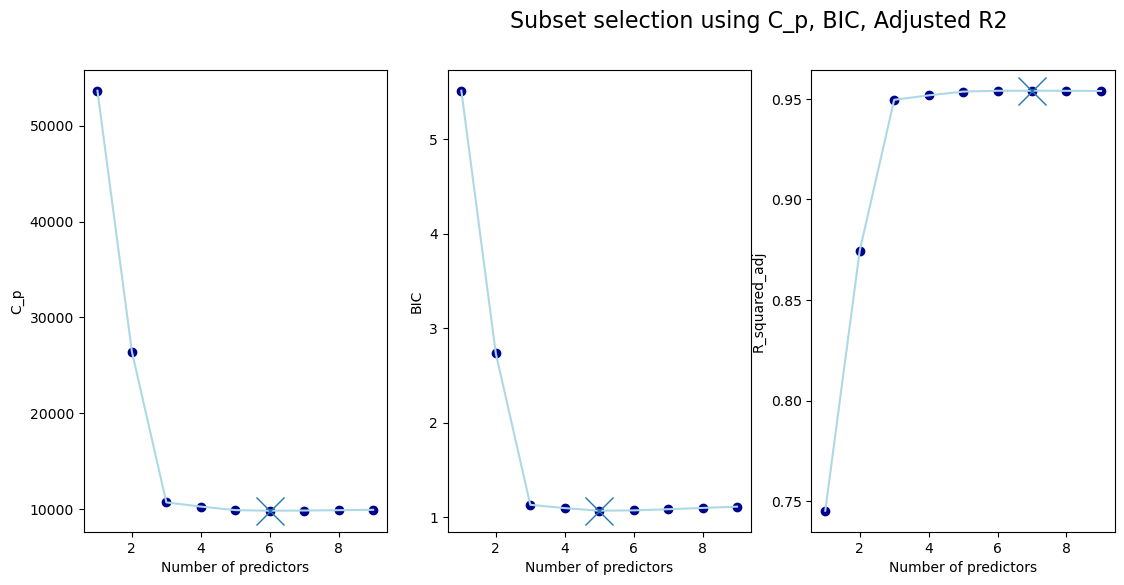

In [32]:
variables = ['C_p', 'BIC','R_squared_adj']
fig = plt.figure(figsize = (18,6))

for i,v in enumerate(variables):
    ax = fig.add_subplot(1, 4, i+1)
    ax.plot(df1['numb_features'],df1[v], color = 'lightblue')
    ax.scatter(df1['numb_features'],df1[v], color = 'darkblue')
    if v == 'R_squared_adj':
        ax.plot(df1[v].idxmax(),df1[v].max(), marker = 'x', markersize = 20)
    else:
        ax.plot(df1[v].idxmin(),df1[v].min(), marker = 'x', markersize = 20)
    ax.set_xlabel('Number of predictors')
    ax.set_ylabel(v)

fig.suptitle('Subset selection using C_p, BIC, Adjusted R2', fontsize = 16)
plt.show()

In addition to the measures above, there are other widely used methods for adding a "penalty" to the use of many variables. Two popular models along these lines are _ridge regression_ and _lasso_ regression:

For _ridge regression_, the measure we attempt to minimize is:

&nbsp;
<center>
    $\displaystyle \sum_{i = 1}^{n}\left(y_{i} - \hat{y}_{i}\right)^{2} + \lambda \sum_{j = 1}^{p}\beta_{j}^{2}$.
</center>
&nbsp;

For _lasso regression_, the model we attempt to minimize is:

&nbsp;
<center>
    $\displaystyle \sum_{i = 1}^{n}\left(y_{i} - \hat{y}_{i}\right)^{2} + \lambda \sum_{j = 1}^{p}|\beta_{j}|$.
</center>
&nbsp;

Both models penalize large values of the coefficients, and so are biased towards $0$. This means the approach will tend to favor underestimating the coefficients. 

Why would we want to do this? Well, if we recall from our first lecture, generally speaking the introduction of bias tends to decrease the variance within our model (the bias-variance tradeoff), and so by decreasing the variance, you decrease the chance that your model will be far removed from the actual "correct" model.

We call the penalty for Ridge regression an $\ell_{2}$ norm, and the penalty for the Lasso is $\ell_{1}$ norm. The different numbers refer to the exponent of the individual $\beta_{i}$ terms. (Note technically to be an $\ell_{2}$ norm, the penalty for ridge regression should have a square root, but don't worry about that here.)

Now, one of the first thing to notice here is that term $\lambda$. What is it, and how do we know its value? Well, the term $\lambda$ is something called a _hyperparameter_. You don't determine it as part of the modeling process - you define it before you start the modeling process. So, you could view both ridge and lasso regression not as single models, but as families of models parametrized by $\lambda$.

At one extreme, $\lambda = 0$, both ridge and lasso regression reduce to standard regression, in which the goal is to minimize $\sum_{i = 1}^{n}\left(y_{i} - \hat{y}_{i}\right)^{2}$. On the other extreme, as $\lambda \rightarrow \infty$, the penalty for any positive coefficient goes to $\infty$, and so the model will tend towards a constant model $Y = \beta_{0}$, where $\beta_{0}$ will just be the average of the output values.

It is between these extremes that we want to build our model, and so how do we figure out $\lambda$? Well, as usual, if we just try to optimize a value like $RSS$ on our training data, we won't get anywhere. Specifically, we'll always choose $\lambda = 0$ by definition.

The validation set approach is conceptually simple and easy to implement. However, it has two potential drawbacks:

1. The validation estimate of the test error rate can be highly variable, and can be highly dependent on precisely which observations are included in the training set vs. the validation set.


2. Only a subset of the observations, those that are included in the training set, are used to fit the model. Since statistical methods tend to perform worse when trained on fewer observations, this suggests that the validation set error rate may _overestimate_ the test error rate for the model when fit on the entire data set.

One way to, partially, address these concerns is by using _cross-validation_, a refinement of the validation set approach that addresses these two issues.

**Leave-One-Out Cross-Valdation (LOOCV)**

For LOOCV, instead of creating two subsets of comparable size as in the validation set approach, a single observation $(x_{i},y_{i})$ is used for the validation set, and the remaining observations make up the training set. The model is then fit on the $n-1$ training observations, and its predicted value $\hat{y}_{i}$ for $x_{i}$ is tested against the actual output $y_{i}$. So, $MSE_{i} = (y_{i}-\hat{y}_{i})^{2}$. This procedure is repeated for all $n$ observations, and the estimated $MSE$ is the average of the errors for each model:

&nbsp;
<center>
    $\displaystyle CV_{(n)} = \frac{1}{n}\sum_{i = 1}^{n}MSE_{i}$.
</center>
&nbsp;

This approach has far less bias than the validation set approach, and removes the randomness and risk inherent in the training / validation set splits. However, it can be computationally expensive.

**k-Fold Cross-Validation**

An alternative to LOOCV is $k$-fold cross-validation (CV). In this approach, we randomly divide the set of observations into $k$ groups, or _folds_, of approximately equal size. The first fold is treated as the validation set, and the model is fit on the remaining $k-1$ folds. The mean squared error of the model on this first fold, $MSE_{1}$, in then computed. Thes is repeated $k$ times, producing $MSE_{1},MSE_{2},\ldots,MSE_{k}$. The $MSE$ estimate is then computed as:

&nbsp;
<center>
    $\displaystyle CV_{(k)} = \frac{1}{k}\sum_{i = 1}^{n}MSE_{i}$.
</center>
&nbsp;

It isn't hard to see that the validation set approach and LOOCV are just special cases of $k$-fold CV, with $k = 2$ and $k = n$ respectively. Which value of $k$ should you use for your model? Well, that's another hyperparameter.

The problem with using a large value of $k$ isn't just the increase in computation time, which for modern computers is rarely a huge concern. Yet again, the problem with using a large value for $k$ is the bias-variance trade-off. For the extreme case of LOOCV, the training data for each model is almost exactly the same, which means the models are highly correlated. This means that, while a larger value of $k$ will decrease the bias in the individual estimates (the tendency to overestimate the error), it will also increase the variance. There's basically no way of getting out of that tradeoff.

We'll talk more about cross-validation in the context of resambling methods next week, but for now let's take a look at how we might calculate $\lambda$ for ridge or lasso regression using cross-validation in Python.

First, we'll import some modules from sklearn that we'll want for Ridge and Lasso regression, along with cross-validation:

In [44]:
#from sklearn import linear_model
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import train_test_split

#from sklearn.preprocessing import scale 

#%matplotlib inline
#plt.style.use('ggplot')

Next, I'll create a set of potential lambdas over a wide range of values. Specifically, I'll create 90 potential $\lambda$ values ranging from $10^{7}$ to $10^{-2}$, with even spacing between the _exponents_.

In [46]:
lambdas = 10**np.linspace(7,-2,90)
lambdas

array([1.00000000e+07, 7.92275825e+06, 6.27700983e+06, 4.97312315e+06,
       3.94008524e+06, 3.12163429e+06, 2.47319538e+06, 1.95945291e+06,
       1.55242717e+06, 1.22995052e+06, 9.74460063e+05, 7.72041151e+05,
       6.11669540e+05, 4.84610990e+05, 3.83945572e+05, 3.04190795e+05,
       2.41003013e+05, 1.90940861e+05, 1.51277828e+05, 1.19853766e+05,
       9.49572415e+04, 7.52323269e+04, 5.96047539e+04, 4.72234056e+04,
       3.74139626e+04, 2.96421781e+04, 2.34847811e+04, 1.86064243e+04,
       1.47414202e+04, 1.16792709e+04, 9.25320396e+03, 7.33108980e+03,
       5.80824522e+03, 4.60173228e+03, 3.64584124e+03, 2.88851187e+03,
       2.28849813e+03, 1.81312174e+03, 1.43649253e+03, 1.13809830e+03,
       9.01687771e+02, 7.14385423e+02, 5.65990301e+02, 4.48420433e+02,
       3.55272668e+02, 2.81473946e+02, 2.23005003e+02, 1.76681473e+02,
       1.39980460e+02, 1.10903134e+02, 8.78658723e+01, 6.96140065e+01,
       5.51534944e+01, 4.36967803e+01, 3.46199027e+01, 2.74285120e+01,
      

Cool. Alright, now I'll set up my output and input values.

Alright, now we're going to do a bunch of ridge regressions, and record the coefficients we get. Note, there's no concensus as to whether the hyperparameter for ridge or lasso regression is a $\lambda$ or an $\alpha$. Most of the teaching literature uses $\lambda$, so I've used it here. Unfortunately, Python uses $\alpha$, which you'll see in the code below.

In [49]:
ridge = Ridge()
coefs = [] #Keep track of the coefficients.

for l in lambdas:
    ridge.set_params(alpha = l) #Ridge regression in Python calls the lambda term alpha.
    ridge.fit(X, y)
    coefs.append(ridge.coef_)

Each of the 90 models should have nine coefficients, so let's check to make sure that's true.

In [51]:
np.shape(coefs)

(90, 9)

Now, let's take a look at how these coefficients change as the value of $\lambda$ (the penalty) increases.

Text(0, 0.5, 'weights')

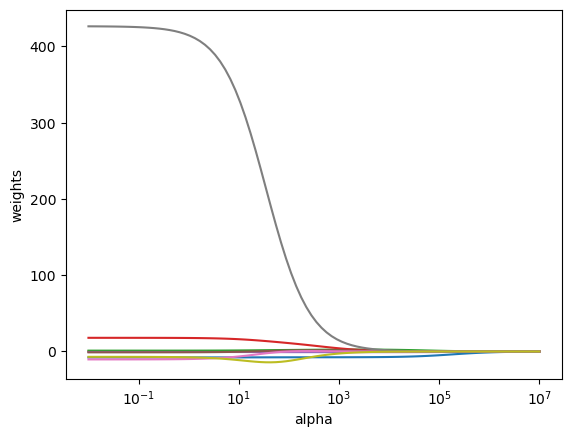

In [53]:
ax = plt.gca()
ax.plot(lambdas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

OK. Let's use sklearn's train_test_split to create a validation set, and check out some coefficients for different values of $\lambda$.

In [55]:
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=2)

For the smaller value of $\lambda = 10^{-1} = .1$:

In [57]:
ridge2 = Ridge(alpha = 1)# Again, Python uses alpha and not lambda, sorry
ridge2.fit(X_train, y_train)             # Fit a ridge regression on the training data
pred2 = ridge2.predict(X_test)           # Use this model to predict the test data
print(pd.Series(ridge2.coef_, index = X.columns)) # Print coefficients
print(mean_squared_error(y_test, pred2))          # Calculate the test MSE

Income        -7.630106
Limit          0.194519
Rating         1.089936
Cards         20.267416
Age           -0.588028
Education     -0.700885
Own            3.574424
Student      407.294136
Married       -9.705093
dtype: float64
9980.59519379909


For the larger value of $\lambda = 10^{7} = 10,000,000$:

In [59]:
ridge3 = Ridge(alpha = 10**7)
ridge3.fit(X_train, y_train)             
pred3 = ridge3.predict(X_test)           
print(pd.Series(ridge3.coef_, index = X.columns)) 
print(mean_squared_error(y_test, pred3))          

Income      -0.063776
Limit        0.166727
Rating       0.016809
Cards        0.000909
Age         -0.014565
Education    0.000383
Own          0.000106
Student      0.000878
Married     -0.000174
dtype: float64
53148.89603739644


And for the standard linear regression situation $\lambda = 0$:

In [61]:
ridge4 = Ridge(alpha = 0)
ridge4.fit(X_train, y_train)             
pred4 = ridge4.predict(X_test)            
print(pd.Series(ridge4.coef_, index = X.columns)) 
print(mean_squared_error(y_test, pred4))           

Income        -7.620455
Limit          0.196122
Rating         1.067382
Cards         20.367600
Age           -0.565695
Education     -0.915714
Own            3.185341
Student      428.677306
Married       -8.748533
dtype: float64
9986.129099705022


So, $\lambda = 10^{-1}$ is a bit better than $\lambda = 0$, but not much.

For ridge regression there is already a function, RidgeCV, that will select the best value of $\lambda$ using cross-validation. The value of the parameter "cv" sets the number of folds, and it defaults to LOOCV.

In [64]:
ridgecv = RidgeCV(alphas = lambdas)
ridgecv.fit(X_train, y_train)
ridgecv.alpha_

0.10262093211115313

Building a ridge regression model with the optimal $\lambda$ from above, we get:

In [66]:
ridge5 = Ridge(alpha = ridgecv.alpha_)
ridge5.fit(X_train, y_train)
mean_squared_error(y_test, ridge5.predict(X_test))

9981.892242529902

With coefficients:

In [68]:
ridge5.fit(X, y)
pd.Series(ridge4.coef_, index = X.columns)

Income        -7.620455
Limit          0.196122
Rating         1.067382
Cards         20.367600
Age           -0.565695
Education     -0.915714
Own            3.185341
Student      428.677306
Married       -8.748533
dtype: float64

With cv = 10 we get:

In [70]:
ridgecv = RidgeCV(alphas = lambdas, cv = 10)
ridgecv.fit(X_train, y_train)
ridgecv.alpha_

0.16348697045064184

In [71]:
ridge6 = Ridge(alpha = ridgecv.alpha_)
ridge6.fit(X_train, y_train)
mean_squared_error(y_test, ridge6.predict(X_test))

9979.810283611805

_Slightly_ better.

In [73]:
ridge6.fit(X, y)
pd.Series(ridge4.coef_, index = X.columns)

Income        -7.620455
Limit          0.196122
Rating         1.067382
Cards         20.367600
Age           -0.565695
Education     -0.915714
Own            3.185341
Student      428.677306
Married       -8.748533
dtype: float64

Note that, while many of these coefficients are small, _none_ are $0$. That will not be the case with lasso regression.

Note that for lasso regression here, it figures out the optimal value using iterative fitting, and we need to specify a maximum number of required iterations. We won't get into why it's different than ridge regression, but it has to do with optimizing squared terms vs. optimizing absolute values - smooth derivatives and all that.

Text(0, 0.5, 'weights')

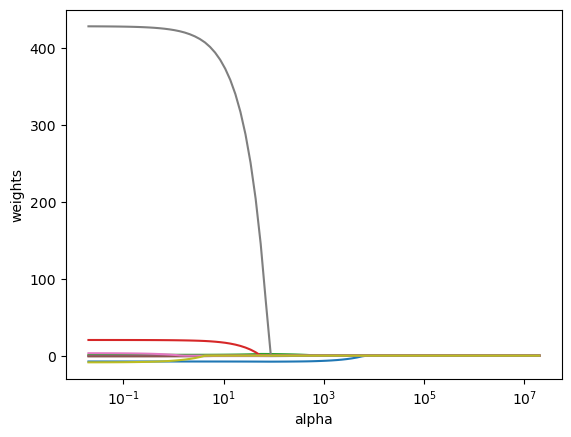

In [76]:
lasso = Lasso(max_iter = 100000)
coefs = []

for l in lambdas:
    lasso.set_params(alpha=l)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)
    
ax = plt.gca()
ax.plot(lambdas*2, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

In [77]:
lassocv = LassoCV(alphas = lambdas, max_iter = 100000)
lassocv.fit(X_train, y_train)

print(lassocv.alpha_)

lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, y_train)
mean_squared_error(y_test, lasso.predict(X_test))

1.0531055707361898


9921.059317086045

In [78]:
pd.Series(lasso.coef_, index=X.columns)

Income        -7.637751
Limit          0.194561
Rating         1.090534
Cards         19.696133
Age           -0.542100
Education     -0.760594
Own            0.000000
Student      418.286555
Married       -4.277255
dtype: float64

The lasso here does a bit better than ridge, and we can see it sets one value, Own, to $0$.

What about for larger values of $\lambda$? Well, here we see that lasso sets many coefficients to $0$.

In [81]:
lasso2 = Lasso(alpha = 10**3, max_iter = 100000)
lasso2.fit(X_train, y_train)             # Fit a ridge regression on the training data
pred5 = lasso2.predict(X_test)           # Use this model to predict the test data
print(pd.Series(lasso2.coef_, index = X.columns)) # Print coefficients
print(mean_squared_error(y_test, pred5))          # Calculate the test MSE

Income      -5.547870
Limit        0.235315
Rating       0.000000
Cards        0.000000
Age         -0.000000
Education    0.000000
Own          0.000000
Student      0.000000
Married     -0.000000
dtype: float64
27485.90270833892


As expected, most of the coefficients are $0$, which is not what we saw for large values of $\lambda$ in ridge regression.